# GTHA housing market database
# OSEMN methodology Step 1: Obtain
# Obtain Enhanced Points of Interest (EPOI) data from DMTI


---

This notebook describes _Step 1: Obtain_ of OSEMN methodology, the process of obtaining of Forward Sortation Areas (FSA) from the Platinum Postal Code Suite created by DMTI Spatial Inc.


Files used in this notebook are downloaded from the [Map and Data Library database](https://mdl.library.utoronto.ca/collections/geospatial-data/platinum-postal-code-suite-4) of the University of Toronto.

## Enhanced Points of Interest (EPOI)
[McGill library](https://www.mcgill.ca/library/find/maps/epoi):
The Enhanced Points of Interest files are produced by DMTI Spatial Inc. The Enhanced Points of Interest (EPOI) file is a national database of over 1 million Canadian business and recreational points of interest. Engineered using CanMap® Streetfiles, each EPOI has been accurately geocoded and precisely placed. This location enriched point of interest database allows users to see and analyze selected point of interest data in a given geographic area, enabling applications such as retail site analysis, competitive and market research, business and tourism analysis. Features Include: Coordinate location (X, Y), Standard industry classification code (SIC), Business or recreational names with address information, and Common Address Flags (CAF) allowing users to identify records with identical addresses. It is recommended to use this with the dataset with CanMap Streetfiles (DMTI).

---

For description of OSEMN methodology, see `methodology/0.osemn/osemn.pdf`.

## Import dependencies

In [1]:
%matplotlib inline
import pandas as pd 
import geopandas as gpd
import os
from time import time

In [2]:
epoi_path = '../../../data/dmti/epoi_gtha13/'
os.listdir(epoi_path)

['epoi_gtha13.sbx',
 'epoi_gtha13.sbn',
 'epoi_gtha13.dbf',
 'epoi_gtha13.shp.xml',
 'epoi_gtha13.cpg',
 'epoi_descriptions',
 'epoi_gtha13.shp',
 'epoi_gtha13.prj',
 'epoi_gtha13.shx']

## Load geometry of Enhanced Points of Interest (EPOI)

----- GeoDataFrame loaded
in 38.55 seconds (0.64 minutes)
with 317,874 rows
and 38 columns
-- Column names:
 Index(['OBJECTID', 'POI_ID', 'NAME', 'UNIT_SUITE', 'ADDRESS', 'DELIV_MODE',
       'CITY', 'MAF', 'PROV', 'POST_CODE', 'LOCATION', 'PHONE', 'FAX',
       'TOLL_FREE', 'WEBSITE', 'EPOI_TYPE', 'CAF', 'SIC_1', 'SIC_2', 'SIC_3',
       'SIC_4', 'SIC_5', 'SIC_6', 'NAICS_1', 'NAICS_2', 'NAICS_3', 'NAICS_4',
       'NAICS_5', 'SIC_MJ_GRP', 'SIC_DIV', 'X', 'Y', 'PREC_CODE', 'ATTRIBCODE',
       'STATUS', 'COMM_NAME', 'GRP_IND', 'geometry'],
      dtype='object')


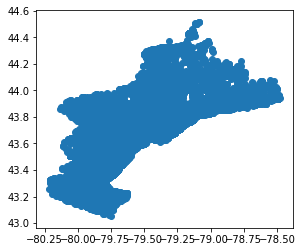

In [3]:
t = time()
epoi_gdf = gpd.read_file(epoi_path + 'epoi_gtha13.shp')
epoi_gdf['SIC_MJ_GRP'] = epoi_gdf['SIC_MJ_GRP'].astype('int')
elapsed = time() - t

print("----- GeoDataFrame loaded"
      "\nin {0:.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(epoi_gdf.shape[0], epoi_gdf.shape[1]) + 
      "\n-- Column names:\n", epoi_gdf.columns)

epoi_gdf.plot();

In [4]:
epoi_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 317874 entries, 0 to 317873
Data columns (total 38 columns):
OBJECTID      317874 non-null int64
POI_ID        317874 non-null object
NAME          317864 non-null object
UNIT_SUITE    6175 non-null object
ADDRESS       290169 non-null object
DELIV_MODE    503 non-null object
CITY          317874 non-null object
MAF           317874 non-null object
PROV          317874 non-null object
POST_CODE     271121 non-null object
LOCATION      481 non-null object
PHONE         300494 non-null object
FAX           44820 non-null object
TOLL_FREE     20244 non-null object
WEBSITE       48127 non-null object
EPOI_TYPE     20470 non-null object
CAF           216613 non-null object
SIC_1         317874 non-null object
SIC_2         317874 non-null object
SIC_3         317874 non-null object
SIC_4         317874 non-null object
SIC_5         317874 non-null object
SIC_6         317874 non-null object
NAICS_1       317874 non-null object
NAICS_

## Find candidate keys

In [5]:
epoi_gdf['POI_ID'].nunique()

317874

In [6]:
len(epoi_gdf)

317874

## Add description columns for SIC Divisions and Major Groups

### Read descriptions from files

In [7]:
desc_path = epoi_path + 'epoi_descriptions/'
os.listdir(desc_path)

['SIC_MJGRP_DESC.TXT', 'SIC_DIV_DESC.TXT']

In [8]:
mjgrp_path = desc_path + 'SIC_MJGRP_DESC.TXT'
mjgrp_df = pd.read_csv(mjgrp_path)
print(mjgrp_df.info())
mjgrp_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 2 columns):
MAJOR_GROUP    85 non-null int64
DESCRIPTION    85 non-null object
dtypes: int64(1), object(1)
memory usage: 1.5+ KB
None


,MAJOR_GROUP,DESCRIPTION
0,1,AGRICULTURAL PRODUCTION CROPS
1,2,AGRICULTURAL PRODUCTION LIVESTOCK AND ANIMAL S...
2,7,AGRICULTURAL SERVICES
3,8,FORESTRY
4,9,"FISHING, HUNTING, AND TRAPPING"


In [9]:
div_path = desc_path + 'SIC_DIV_DESC.TXT'
div_df = pd.read_csv(div_path)
print(div_df.info())
div_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 2 columns):
DIVISION       11 non-null object
DESCRIPTION    11 non-null object
dtypes: object(2)
memory usage: 304.0+ bytes
None


,DIVISION,DESCRIPTION
0,A,"AGRICULTURE, FORESTRY, AND FISHING"
1,B,MINING
2,C,CONSTRUCTION
3,D,MANUFACTURING
4,E,"TRANSPORTATION, COMMUNICATIONS, ELECTRIC, GAS,..."


### Join descriptions to EPOI GeoDataFrame

In [10]:
epoi_crs = epoi_gdf.crs
epoi_gdf = pd.merge(epoi_gdf, mjgrp_df, left_on='SIC_MJ_GRP', right_on='MAJOR_GROUP', how='left')
epoi_gdf = epoi_gdf.drop('MAJOR_GROUP', axis=1).rename(columns={'DESCRIPTION': 'MJGRP_DESC'})
epoi_gdf = pd.merge(epoi_gdf, div_df, left_on='SIC_DIV', right_on='DIVISION', how='left')
epoi_gdf = epoi_gdf.drop('DIVISION', axis=1).rename(columns={'DESCRIPTION': 'DIV_DESC'})
epoi_gdf[['SIC_MJ_GRP', 'MJGRP_DESC', 'SIC_DIV', 'DIV_DESC']].head()

,SIC_MJ_GRP,MJGRP_DESC,SIC_DIV,DIV_DESC
0,72,PERSONAL SERVICES,I,SERVICES
1,76,MISCELLANEOUS REPAIR SERVICES,I,SERVICES
2,81,LEGAL SERVICES,I,SERVICES
3,73,BUSINESS SERVICES,I,SERVICES
4,59,MISCELLANEOUS RETAIL,G,RETAIL TRADE


## Save results to a .csv file

In [11]:
save_path = epoi_path + '../dmti_epoi_gtha13.csv'
t = time()
epoi_gdf.to_csv(save_path, index=False)
elapsed = time() - t
print("DataFrame saved to file:\n", save_path,
      "\ntook {0:.2f} seconds ({1:,.2f} minutes)".format(elapsed, elapsed / 60))

DataFrame saved to file:
 ../../../data/dmti/epoi_gtha13/../dmti_epoi_gtha13.csv 
took 22.40 seconds (0.37 minutes)
